# Deep Mixture Networks

This notebook is a continuation of the neoneo notebook however with the intention of nailing down more of the sticky details than trying to get it to work. To that end, most of the actual mixture network things has been moved to the neoneo.py module and will simply be imported here for use.

The goal of this notebook is to experiment with performance improvements with changing the FeedForward function for example:

Does using the Malahanobis distance versus the log probability versus true probability improve the interestingness of the higher levels?

What kind of normalization can also help compensate.

How hard is it to learn from the final vector

Hopefully by moving these questions to this notebook, neoneo can be reserved for exploring more architecture-based questions

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal, Categorical
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.nn.utils.clip_grad import clip_grad_value_, clip_grad_norm_

import string
from random import *
import re
import math
import time

import subprocess, os, glob
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as st

device = 'cuda:3'
print (device)

print (os.getcwd())

print(torch.__version__)

from multimodal import MultiModalClassification
from GMM import *
from dennytools.silence import *

from neoneo import *
from COPCA import COPCA, OPCA

cuda:3
/home/tbjackso/MemStateEvolution
1.0.0


In [2]:
BS = 100

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=BS, shuffle=True, pin_memory=False)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=BS, shuffle=True, pin_memory=False)

# Training dataset
big_batch = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=500, shuffle=True, pin_memory=False)

In [3]:
def forward(Ls, Ns, data, full=False):
    device = next(Ls[0].parameters()).device
    dd = data.to(device)
    
    Ys = [dd]

    for l,L in enumerate(Ls):
#         (pi, sig, mu) = [x.cpu().detach() for x in L.params()]
#         pi = pi.squeeze()
#         vp,pp = pi.sort(descending=True)

        (y,_) = L(dd)

        # Normalize
        if (Ns is None):
            dd = y
        else:
            dd = Ns[l](y)
            
        Ys.append(y)
        
    if (full):
        return Ys
    else:
        return Ys[-1]
    
def doEpoch(Ls, Ns, data_loader, learn):
    device = next(Ls[0].parameters()).device
    loss = [0 for L in Ls]
    for (data, label) in data_loader:
        p = data.to(device)
        for i,L in enumerate(Ls):
            # Calculate Forward
            (x,_) = L(p)

            # calculate loss
            loss[i] += L.loss(p).item()

            # Learn
            if (learn is True or learn == i):
                L.learn(p)

            # Normalize
            if (Ns is None):
                p = x
            else:
                p = Ns[i](x)

    loss.append(sum(loss))
    return loss
            

def train(Ls, Ns, data_loader, rounds, epochs, layer_learn=False, hardness=False, verbose=False):

    device = next(Ls[0].parameters()).device

    epochs = epochs*len(Ls) if (layer_learn) else epochs
    hist = np.zeros((rounds*epochs+1, len(Ls)+1))
    hard = np.zeros((rounds*epochs+1, len(Ls)))
    
    print ("Gathering Initial Statistics...")
    hist[0] = doEpoch(Ls, Ns, data_loader, False)
    
    if (hardness):
        for i in range(len(Ls)):
            hard[0, i] = MeasureHardness(Ls[:i+1], Ns, 30, data_loader, epochs=5, lr=5e-3, verbose=verbose)


    try:
        for r in range(rounds):
            s = time.time()
            print ("Round: {}/{}".format(r+1,rounds))

            for e in range(epochs):
                    
                if (layer_learn):
                    loss = doEpoch(Ls, Ns, data_loader, e//len(Ls))
                else:
                    loss = doEpoch(Ls, Ns, data_loader, True)

                # Measure hardness of each layer
                if (hardness):
                    for i in range(len(Ls)):
                        hard[epochs*r+e+1, i] = MeasureHardness(Ls[:i+1], Ns, 30, data_loader, epochs=5, lr=5e-3, verbose=verbose)

                hist[epochs*r+e+1] = loss
                pstr = "Epoch {} : "+", ".join(["{:.2f}"]*len(Ls)) +" :: {:.2f}"
                print (pstr.format(*([e]+loss)))
            e = time.time()
            print ("Round {} runtime: {}\n".format(r,e-s))
            
    except KeyboardInterrupt:
        hist = hist[:(r*epochs)+e]
        hard = hard[:(r*epochs)+e]
    
    if (hardness):
        return (hist, hard)
    else:
        return hist



            
# TODO 
# Define proper class for this deep conv net?
# Write function that trains one or two layer neural network against the outpits of
# the predictive learned behaviour and measures how quickly learning takes place
class FCNet(nn.Module):
    def __init__(self, inputs, hidden, classes):
        super(FCNet, self).__init__()
#         self.L1 = nn.Linear(inputs, hidden)
#         self.L2 = nn.Linear(hidden, classes)
        self.L  = nn.Linear(inputs, classes)
        self.inputs = inputs
        
    def forward(self, x):
        x1 = x.view(-1, self.inputs)
#         x2 = F.relu(self.L1(x1))
        x3 = self.L(x1)
#         x3 = self.L2(x2)
        return x3
        

def MeasureHardness(Ls, Ns, hidden, data_loader, test=None, epochs=10, lr=1e-3, verbose=False):
    device = next(Ls[0].parameters()).device
    
    net = FCNet(Ls[-1].G*Ls[-1].L, hidden, 10).to(device)
    opt = optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    with silence(not verbose):
        hardness = 0
        for e in range(epochs):
            Tloss = 0
            Tacc = 0
            for data, label in data_loader:
                data = data.to(device)
                label = label.to(device)

                x = forward(Ls, Ns, data)

                opt.zero_grad()
                y = net(x)

                bloss = loss(y, label)
                Tloss += bloss.item()
                bloss.backward()

                opt.step()

                acc = (y.argmax(-1) == label).float().mean().item()

                Tacc += acc/len(data_loader)
                
            if (test is not None):
                Tacc = 0
                for (data, label) in test:
                    
                    data = data.to(device)
                    label = label.to(device)
                    
                    x = forward(Ls, Ns, data)
                    y = net(x)
                    
                    acc = (y.argmax(-1) == label).float().mean().item()

                    Tacc += acc/len(test)
            
            hardness += Tacc/epochs

            print ("Epoch: {} Acc: {:.2f} Loss: {:.2f}".format(e, 100*Tacc, Tloss))
            
    return hardness

def MeasureHardnessBaseline(CNet, inputs, hidden, data_loader, test=None, epochs=10, lr=1e-3, verbose=False):
    device = next(CNet.parameters()).device
    
    net = FCNet(inputs, hidden, 10).to(device)
    opt = optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    with silence(not verbose):
        hardness = 0
        for e in range(epochs):
            Tloss = 0
            Tacc = 0
            for data, label in data_loader:
                data = data.to(device)
                label = label.to(device)

                x = CNet(data)

                opt.zero_grad()
                y = net(x)

                bloss = loss(y, label)
                Tloss += bloss.item()
                bloss.backward()

                opt.step()

                acc = (y.argmax(-1) == label).float().mean().item()

                Tacc += acc/len(data_loader)
                
            if (test is not None):
                Tacc = 0
                for (data, label) in test:
                    
                    data = data.to(device)
                    label = label.to(device)
                    
                    x = CNet(data)
                    y = net(x)
                    
                    acc = (y.argmax(-1) == label).float().mean().item()

                    Tacc += acc/len(test)
            
            hardness += Tacc/epochs

            print ("Epoch: {} Acc: {:.2f} Loss: {:.2f}".format(e, 100*Tacc, Tloss))
            
    return hardness

In [22]:
# Transfer functions and Network builder

def cossim(x, pi, sig, mu):
    x = x.unsqueeze(1)/sig
    mu = mu/sig
    return F.cosine_similarity(x, mu, 2, 1e-8)

def GMMLogProbs(batch, pi, sigmas, mus, reduce=True, log=False, stable=False, normalize=False):
    logpi = pi.log()
    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    
    return g_log_probs

def MixtureLogProb(x, pi, sig, mu):
    if (len(x.shape)==2):
        x = x.unsqueeze(1)
        
    mal_dist = ((x-mu)**2/sig).sum(-1)
    log_prob = torch.log(pi) + mal_dist
    
    return log_prob

def mahalanobis(x, pi, sig, mu):
    x = x.unsqueeze(1)
    mal_dist = ((x-mu)**2/sig).sum(-1)
    return mal_dist

def scaledMahan(x,pi,sig, mu):
    x = x.unsqueeze(1)
    x = x/(x.sum(-1, keepdim=True)+1e-8)
    mu = mu/(mu.sum(-1, keepdim=True)+1e-8)
    mal_dist = ((x-mu)**2/sig).sum(-1)
    return mal_dist

def upsidedown(x, pi, sig, mu):
    x = x.unsqueeze(1)
    mal_dist = ((x-mu)**2/sig).sum(-1)
    return 1/(mal_dist+1)

def upsydaisy(x, pi, sig, mu):
    x = x.unsqueeze(1)
    # L1 normalize
    x = x/(x.sum(-1, keepdim=True)+1e-8)
    mu = mu/(mu.sum(-1, keepdim=True)+1e-8)
    mal_dist = ((x-mu)**2/sig).sum(-1)
    return 1/(mal_dist+1)

def makeNet(func, N, device, pre=None, Gs=[15,20,25,30,30], Ps=None, lr=5e-3, min_sig=0.01, start_sig=None):

    L0 = CGMN((1,28,28), Gs[0], (3,3), lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L0.to(device)

    L1 = CGMN((Gs[0],26,26), Gs[1], (3,3), stride=2, lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L1.to(device)

    L2 = CGMN((Gs[1],12,12), Gs[2], (3,3), stride=2, lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L2.to(device)

    L3 = CGMN((Gs[2],5,5), Gs[3], (3,3), lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L3.to(device)
    
    L4 = CGMN((Gs[3],3,3), Gs[4], (3,3), lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L4.to(device)

    Ls = [L0, L1, L2, L3, L4]
    Ns = [N]*len(Ls)
    return (Ls, Ns)

def makeNet2(func, N, device, pre=None, Gs=[15,20,25,30,30], Ps=[5,5,5,5,5], lr=5e-3, min_sig=0.01, start_sig=None):

    L0 = CGMN((1,28,28), Gs[0], (3,3), lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L0.to(device)
    
    P0 = COPCA((Gs[0],26,26), Ps[0], (1,1)).eval()
    P0.to(device)

    L1 = CGMN((Ps[0],26,26), Gs[1], (3,3), stride=2, lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L1.to(device)

    P1 = COPCA((Gs[1],12,12), Ps[1], (1,1)).eval()
    P1.to(device)

    L2 = CGMN((Ps[1],12,12), Gs[2], (3,3), stride=2, lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L2.to(device)

    P2 = COPCA((Gs[2],5,5), Ps[2], (1,1)).eval()
    P2.to(device)

    L3 = CGMN((Ps[2],5,5), Gs[3], (3,3), lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L3.to(device)
    
    P3 = COPCA((Gs[3],3,3), Ps[3], (1,1)).eval()
    P3.to(device)

    L4 = CGMN((Ps[3],3,3), Gs[4], (3,3), lr=lr, FeedForward=func, pre=pre, min_sig=min_sig, start_sig=start_sig).eval()
    L4.to(device)

    Ls = [L0, P0, L1, P1, L2, P2, L3, P3, L4]
    Ns = [N]*(2*len(Ls)-1)
    return (Ls, Ns)

# Linear Decoding of MNIST
This next cell just performs the hardness test against RAW MNIST
It does amazingly well on the training error

In [17]:


class dummyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.A = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        return x
    
CNet = dummyNet().to(device)

print (MeasureHardnessBaseline(CNet, 784, 0, train_loader, test=test_loader, lr=5e-3, verbose=True))

Epoch: 0 Acc: 92.06 Loss: 231.21
Epoch: 1 Acc: 92.29 Loss: 172.36
Epoch: 2 Acc: 92.49 Loss: 164.59
Epoch: 3 Acc: 92.01 Loss: 160.76
Epoch: 4 Acc: 92.52 Loss: 158.56
Epoch: 5 Acc: 92.42 Loss: 156.07
Epoch: 6 Acc: 92.28 Loss: 154.31
Epoch: 7 Acc: 92.43 Loss: 154.38
Epoch: 8 Acc: 92.44 Loss: 152.82
Epoch: 9 Acc: 92.61 Loss: 151.23
0.9235499826669695


## Hardness of CNNs
Baseline comparison here I'm training a CNN to get a baseline for the hardness If the hardnesses are similar, it indicates that what is being learned from the predictive rule is at least as good to learn from as a trained CNN we also want to compare to an untrained CNN in order to get upper and lower limits

In [ ]:
   
class DeepCNN(nn.Module):
    def __init__(self, N=F.relu):
        super().__init__()
        
        self.C0 = nn.Conv2d(1, 15, 3)
        self.C1 = nn.Conv2d(15, 20, 3, stride=2)
        self.C2 = nn.Conv2d(20, 25, 3, stride=2)
        self.C3 = nn.Conv2d(25, 30, 5)
        
        self.N = N
        
    def forward(self, x):
        x1 = self.C0(x)
        x1 = self.N(x1)
        x2 = self.C1(x1)
        x2 = self.N(x2)
        x3 = self.C2(x2)
        x3 = self.N(x3)
        y = self.C3(x3)
        
        return y
    
    def learn(self, x, lr=None):
        pass

CNet = DeepCNN().to(device)
FNet = FCNet(30, 100, 10).to(device)

optC = optim.Adam(CNet.parameters(), lr=5e-3)
optF = optim.Adam(FNet.parameters(), lr=5e-3)

criteria = nn.CrossEntropyLoss()

epochs = 5

for e in range(epochs):
    TLoss = 0
    TAcc = 0
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optC.zero_grad()
        optF.zero_grad()
        x = CNet(data)
        y = FNet(x)
        
        loss = criteria(y, label)
        TLoss += loss.item()
        loss.backward()
        
        optC.step()
        optF.step()
        
        acc = (y.argmax(-1) == label).float().mean().item()

        TAcc += acc/len(train_loader)
        
    print ("Epoch {}: {:.2f}% {:.2f}".format(e, TAcc*100, TLoss))
        
print (MeasureHardnessBaseline(CNet, 30, 100, train_loader, lr=5e-3, verbose=True))
CNet = DeepCNN().to(device)
print (MeasureHardnessBaseline(CNet, 30, 100, train_loader, lr=5e-3, verbose=True))
        
        

In [ ]:
LsMD, NsMD = makeNet(mahalanobis, lambda x:x/x.mean(), device, Gs =[15,20,30,60,240], lr=[5e-3,0,5e-3])
# print (MeasureHardness(LsCS, NsCS, 100, train_loader, lr=5e-3, verbose=True))

hist, hard = train(LsMD, NsMD, train_loader, 1, 10, layer_learn=True, hardness=True, verbose=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.plot(hist[:,3]/np.abs(hist[:,4]).max(), label='L4')
plt.legend()
plt.show()

plt.plot(hard[:,0], label='L0')
plt.plot(hard[:,1], label='L1')
plt.plot(hard[:,2], label='L2')
plt.plot(hard[:,3], label='L3')
plt.plot(hard[:,4], label='L4')
plt.legend()
plt.show()

In [ ]:
LsMD, NsMD = makeNet(mahalanobis, lambda x:x/x.mean(), device, Gs =[15,20,30,60,240], lr=[5e-3,0,5e-3], min_sig=1.0)
# print (MeasureHardness(LsCS, NsCS, 100, train_loader, lr=5e-3, verbose=True))

hist, hard = train(LsMD, NsMD, train_loader, 1, 50, layer_learn=False, hardness=True, verbose=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.plot(hist[:,3]/np.abs(hist[:,4]).max(), label='L4')
plt.legend()
plt.show()

plt.plot(hard[:,0], label='L0')
plt.plot(hard[:,1], label='L1')
plt.plot(hard[:,2], label='L2')
plt.plot(hard[:,3], label='L3')
plt.plot(hard[:,4], label='L4')
plt.legend()
plt.show()

In [ ]:
LsLP, NsLP = makeNet(MixtureLogProb, lambda x:x/x.mean(), device, Gs =[15,20,30,60,240], lr=[5e-3,0,5e-3])
# print (MeasureHardness(LsCS, NsCS, 100, train_loader, lr=5e-3, verbose=True))

hist, hard = train(LsLP, NsLP, train_loader, 1, 10, layer_learn=False, hardness=True, verbose=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.plot(hist[:,3]/np.abs(hist[:,4]).max(), label='L4')
plt.legend()
plt.show()

plt.plot(hard[:,0], label='L0')
plt.plot(hard[:,1], label='L1')
plt.plot(hard[:,2], label='L2')
plt.plot(hard[:,3], label='L3')
plt.plot(hard[:,4], label='L4')
plt.legend()
plt.show()

In [ ]:
plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.plot(hist[:,3]/np.abs(hist[:,4]).max(), label='L4')
plt.legend()
plt.show()

plt.plot(hard[:,0], label='L0')
plt.plot(hard[:,1], label='L1')
plt.plot(hard[:,2], label='L2')
plt.plot(hard[:,3], label='L3')
plt.plot(hard[:,4], label='L4')
plt.ylim(bottom=0.6)
plt.legend()
plt.show()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from GMM import *

class Adam(nn.Module):
    def __init__(self, param, betas=(0.9, 0.999), eps=1e-8):
        super(Adam, self).__init__()
        self.register_buffer('beta1', torch.tensor(betas[0]))
        self.register_buffer('beta2', torch.tensor(betas[1]))
        self.register_buffer('eps', torch.tensor(eps))
        
        self.register_buffer('m', torch.zeros_like(param))
        self.register_buffer('v', torch.zeros_like(param))
        self.register_buffer('t', torch.tensor(0.0))
        
    def forward(self, g):
        self.m = self.beta1 * self.m + (1-self.beta1) * g
        self.v = self.beta2 * self.v + (1-self.beta2) * g**2
        self.t += 1
        
        m_hat = self.m/(1 - self.beta1**self.t)
        v_hat = self.v/(1 - self.beta2**self.t)
        
        return m_hat / (torch.sqrt(v_hat) + self.eps)

def cleanlr(lr, l):
    if (not isinstance(lr, (list, tuple))):
        lr = [lr]*l

    if (len(lr) != l):
        raise ValueError("Learning Rates must be length 3")
        
    return lr

class GMN(nn.Module):
    def __init__(self, inputs, gaussians, lr=1e-3, min_sig=0.01, start_sig=None,
                 Loss=GMMLoss, FeedForward=MixtureLogProb, pre=None):
        super(GMN, self).__init__()
        self.inputs = inputs
        self.gaussians = gaussians
        
        if (start_sig is not None):
            start_sig = torch.log(torch.tensor(start_sig).float())
            self.Sigs = nn.Parameter(start_sig*torch.ones(1,gaussians, inputs))
        else:
            self.Sigs = nn.Parameter(torch.randn((1, gaussians, inputs)))
        
        self.Pis = nn.Parameter(torch.randn((1, gaussians)))
        self.Mus = nn.Parameter(torch.randn((1, gaussians, inputs)))
    
        self.Pi_adam = Adam(self.Pis)
        self.Sig_adam = Adam(self.Sigs)
        self.Mu_adam = Adam(self.Mus)
        
        self.lr = cleanlr(lr, 3)
        self.min_sig = torch.log(torch.tensor(min_sig).float())
        
        self.FF = FeedForward
        self._loss = Loss
        self.pre = pre if pre is not None else lambda x:x
    
    def params(self):  
        Pis = F.softmax(self.Pis, dim=1)
        Sigs = self.Sigs.exp()
        Mus =  self.Mus
        
        return (Pis, Sigs, Mus)
    
    def forward(self, x, lr=None):
        # This returns both the p vector to higher levels and the dP/dx for feed back
        # If in training mode it will also perform update of this layer's parameters
        
        (pi, sig, mu) = self.params()
        xt = torch.zeros_like(x, requires_grad=True)
        xt.data = x
        x = self.pre(xt)
        
        # Do parameter learning
#         if (self.training):
#             self.learn(x, lr)
            
        p = self.FF(x, pi, sig, mu)
        
        # Calculate backwards vector
        loss = self._loss(x, pi, sig, mu)
        loss.backward()
        dpdx = xt.grad
        
        
        return (p.detach(), dpdx.detach())
    
    def learn(self, x, lr=None):
        
        x = self.pre(x)
        
        (pi, sig, mu) = self.params()
        
        if (lr is None):
            lr = self.lr
        lr = cleanlr(lr, 3)
            
        self.Pis.grad = torch.zeros_like(self.Pis)
        self.Sigs.grad = torch.zeros_like(self.Sigs)
        self.Mus.grad = torch.zeros_like(self.Mus) 
            
        loss = self._loss(x, pi, sig, mu)
        loss.backward()
        
        self.Pis.data  -= lr[0]*self.Pi_adam(self.Pis.grad)
        self.Sigs.data -= lr[1]*self.Sig_adam(self.Sigs.grad)#.clamp(0.01)
        self.Mus.data  -= lr[2]*self.Mu_adam(self.Mus.grad)
        
        # Range bounding
        self.Sigs.data = torch.clamp(self.Sigs, min=self.min_sig)
        
    def loss(self, x):
        x = self.pre(x)
        (pi, sig, mu) = self.params()
        return self._loss(x, pi, sig, mu)
    
class LGMN(GMN):
    def __init__(self, inputs, hiddens, gaussians, lr=1e-3, min_sig=0.01,
                 Loss=GMMLoss, FeedForward=MixtureLogProb):
        super(LGMN, self).__init__(hiddens, gaussians, lr=1e-3, min_sig=0.01,
                 Loss=GMMLoss, FeedForward=MixtureLogProb)
        
        self.W = nn.Parameter(torch.randn((inputs, hiddens)))
        self.b = nn.Parameter(torch.zeros(hiddens))
        
        self.W_adam = Adam(self.W)
        self.b_adam = Adam(self.b)
        

    def forward(self, x):
        x1 = torch.einsum('ij,bi->bj', [self.W, x]) + self.b
        (y, dydx1) = super(LGMN, self).forward(x1)
        dydx = torch.einsum('ij,bj->bi', [self.W, dydx1])
        return (y, dydx)
    
    def learn(self, x, lr=None):
    
        if (lr is None):
            lr = self.lr
            
        self.W.grad = torch.zeros_like(self.W)
        self.b.grad = torch.zeros_like(self.b)
        
        x1 = torch.einsum('ij,bi->bj', [self.W, x]) + self.b
        
        super(LGMN, self).learn(x1, lr)
        
        self.W.data -= lr*self.W_adam(self.W.grad)
        self.b.data -= lr*self.b_adam(self.b.grad)
        
    def loss(self, x):
        x1 = torch.einsum('ij,bi->bj', [self.W, x]) + self.b
        return super(LGMN, self).loss(x1)
        
        

####################################################################
#                        Convolutor                                #
####################################################################

class Convolutor(nn.Module):
    def __init__(self, in_size, out_channels, kernel_size, stride=1):
        super(Convolutor, self).__init__()
        
        (k0, k1) = kernel_size
        (c,h,w) = in_size
        
        # D1 = product of kernel dims and input channels
        D = c * k0 * k1
        hp = (h-k0)//stride+1
        wp = (w-k1)//stride+1
        L = hp*wp
        
        self.L = L
        self.D = D
        self.C = c
        self.K = kernel_size
        self.G = out_channels
        
        self.unfold = nn.Unfold(kernel_size, stride=stride)
        self.fold_forward  = nn.Fold((hp,wp), (1,1), stride=1)
        self.fold_backward = nn.Fold((h,w), kernel_size, stride=stride)
        self.Process = None
        
        temp = torch.zeros((1,D,L))
        self.normalizer = nn.Parameter(self.fold_backward(temp), requires_grad=False)
        
    def forward(self, x):
        (bs,c,h,w) = x.shape
        x1 = self.unfold(x).transpose(1,2).contiguous().view(-1, self.D)
        (yuf, dx1) = self.Process(x1)
        y = self.fold_forward(yuf.view(bs,self.L,self.G).transpose(1,2))
        dx = self.fold_backward(dx1.view(bs,self.L,self.D).transpose(1,2))/self.normalizer
        return (y, dx)
    
    def learn(self, x):
        x1 = self.unfold(x).view(-1, self.D)
        self.Process.learn(x1)
        
    def params(self):
        return self.Process.params()
    
    def loss(self, x):
        x1 = self.unfold(x).view(-1, self.D)
        return self.Process.loss(x1)
        



####################################################################
#                        Convolutional GMN                         #
####################################################################

class CGMN(Convolutor):
    def __init__(self, in_size, out_channels, kernel_size, stride=1, lr=1e-3,
                Loss=GMMLoss, FeedForward=MixtureLogProb, pre=None, min_sig=0.01, start_sig=None):
        super(CGMN, self).__init__(in_size, out_channels, kernel_size, stride)
        self.Process = GMN(self.D, out_channels, lr=lr, Loss=Loss, FeedForward=FeedForward,
                           pre=pre, min_sig=min_sig, start_sig=start_sig)
        
    def params(self, reshape=False):
        (pi, sig, mu) =  self.Process.params()
        mss = sig.shape
        if (reshape):
            mss = (self.G, self.C)+self.K
        return (pi, sig.view(mss), mu.view(mss))
        
class CLGMN(Convolutor):
    def __init__(self, in_size, hidden, out_channels, kernel_size, stride=1, lr=1e-3,
                Loss=GMMLoss, FeedForward=MixtureLogProb, min_sig=0.01):
        super(CLGMN, self).__init__(in_size, out_channels, kernel_size, stride)
        self.Process = LGMN(self.D, hidden, out_channels, lr=lr, Loss=Loss, FeedForward=FeedForward, min_sig=min_sig)
        
    def params(self, reshape=False):
        (pi, sig, mu) =  self.Process.params()
        mss = sig.shape
        if (reshape):
            pass
#             mss = (self.G, self.C)+self.K
        return (pi, sig.view(mss), mu.view(mss))

Layer 0: 0.37852665736277846
Layer 1: 0.8277933132288344
Layer 2: 0.10157333048433052
Layer 3: 0.10332999719306817
Layer 4: 0.10118999717012032
Layer 5: 0.10526333044469344
Layer 6: 0.10107999728247515
Layer 7: 0.10610666384796287
Layer 8: 0.10092333057088147
Gathering Initial Statistics...
Round: 1/1
Epoch 0 : 17329.36, 0.00, 34758.49, 0.00, 34761.33, 0.00, 34758.36, 0.00, 34756.74 :: 156364.29
Epoch 1 : 17292.82, 0.00, 34639.57, 0.00, 34629.75, 0.00, 34627.14, 0.00, 34598.85 :: 155788.13
Epoch 2 : 17258.77, 0.00, 34561.85, 0.00, 34539.89, 0.00, 34539.25, 0.00, 34470.02 :: 155369.78
Epoch 3 : 17225.50, 0.00, 34492.21, 0.00, 34467.30, 0.00, 34466.77, 0.00, 34388.92 :: 155040.71
Epoch 4 : 17192.78, 0.00, 34425.17, 0.00, 34398.96, 0.00, 34398.48, 0.00, 34317.51 :: 154732.91
Epoch 5 : 17160.34, 0.00, 34358.99, 0.00, 34332.32, 0.00, 34331.85, 0.00, 34249.50 :: 154433.01
Epoch 6 : 17127.89, 0.00, 34293.97, 0.00, 34266.57, 0.00, 34266.12, 0.00, 34182.94 :: 154137.49
Epoch 7 : 17095.45, 0.00,

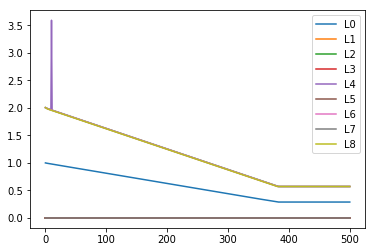

Layer 0: 0.3785 -> 0.2477
Layer 1: 0.8278 -> 0.7400
Layer 2: 0.1016 -> 0.1000
Layer 3: 0.1033 -> 0.1604
Layer 4: 0.1012 -> 0.1013
Layer 5: 0.1053 -> 0.1032
Layer 6: 0.1011 -> 0.1003
Layer 7: 0.1061 -> 0.1044
Layer 8: 0.1009 -> 0.1010


In [38]:
# RUN THIS NEXT!!!!
# Ls, Ns = makeNet(GMMProbs, lambda x:x/x.mean(), device, Gs=[15,20,30,60,240], lr=[5e-3,5e-3,5e-3], min_sig=1.0)
# Ls, Ns = makeNet(GMMLogProbs, lambda x:x/x.mean(), device, Gs=[15,20,30,60,240], lr=[5e-3,5e-3,5e-3], min_sig=1.0)
# Ls, Ns = makeNet(MixtureLogProb, lambda x:x/x.mean(), device, Gs=[15,20,30,60,240], lr=[5e-3,5e-3,5e-3], min_sig=1.0)
# Ls, Ns = makeNet2(mahalanobis, lambda x:x/x.mean(0), device, Gs=[15,20,30,60,240], Ps=[2,2,2,2,2], lr=[5e-3,1e-4,5e-3], min_sig=1, start_sig=10)
# Ls, Ns = makeNet2(upsidedown, lambda x:x, device, Gs=[15,20,30,60,240], Ps=[2,2,2,2,2], lr=[5e-3,1e-3,5e-3], min_sig=1, start_sig=10)
# Ls, Ns = makeNet2(upsydaisy, lambda x:x, device, Gs=[15,20,30,60,240], Ps=[5,5,5,5,5], lr=[5e-3,1e-3,5e-3], min_sig=1, start_sig=10)
# Ls, Ns = makeNet2(scaledMahan, lambda x:x/x.mean(0), device, Gs=[15,20,30,60,240], Ps=[5,5,5,5,5], lr=[5e-3,1e-4,5e-3], min_sig=1, start_sig=10)
# Ls, Ns = makeNet2(mahalanobis, lambda x:x/(x.sum(1, keepdim=True)+1e-8), device, Gs=[15,20,30,60,240], Ps=[5,5,5,5,5], lr=[5e-3,1e-4,5e-3], min_sig=1, start_sig=10)
# Ls, Ns = makeNet(mahalanobis, lambda x:x, device, pre=lambda x:x/(x.sum(-1, keepdim=True)+1e-8), Gs=[15,20,30,60,240], Ps=[5,5,5,5,5], lr=[5e-3,1e-5,5e-3], min_sig=1, start_sig=10)
Ls, Ns = makeNet2(upsidedown, lambda x:x, device, pre=lambda x:x/(x.sum(-1, keepdim=True)+1e-8), Gs=[15,20,30,60,240], Ps=[2,2,2,2,2], lr=[5e-3,1e-5,5e-3], min_sig=1, start_sig=10)

hardpre = []
for i in range(len(Ls)):
    hardpre.append(MeasureHardness(Ls[:i+1], Ns, 30, train_loader, epochs=5, lr=5e-3))
    print ("Layer {}: {}".format(i, hardpre[-1]))
    
hist = train(Ls, Ns, train_loader, 1, 500, layer_learn=False, hardness=False, verbose=True)

hardpost = []
for i in range(len(Ls)):
    hardpost.append(MeasureHardness(Ls[:i+1], Ns, 30, train_loader, epochs=5, lr=5e-3))
    print ("Layer {}: {}".format(i, hardpost[-1]))

for l,L in enumerate(Ls):
    plt.plot(hist[:,l]/np.abs(hist[:,0]).max(), label='L'+str(l))
plt.legend()
plt.show()

for i in range(len(hardpre)):
    h1 = hardpre[i]
    h2 = hardpost[i]
    print ("Layer {}: {:.4f} -> {:.4f}".format(i,h1,h2))

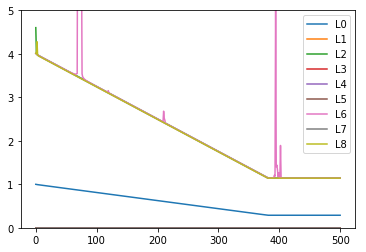

Layer 0: 0.3666 -> 0.2641
Layer 1: 0.8386 -> 0.8197
Layer 2: 0.1141 -> 0.1018
Layer 3: 0.1158 -> 0.1052
Layer 4: 0.1011 -> 0.1524
Layer 5: 0.1053 -> 0.1333
Layer 6: 0.1018 -> 0.1045
Layer 7: 0.1070 -> 0.1069
Layer 8: 0.1032 -> 0.1011


In [36]:
for l,L in enumerate(Ls):
    plt.plot(hist[:,l]/np.abs(hist[:,0]).max(), label='L'+str(l))
plt.ylim((0,5))
plt.legend()
plt.show()

for i in range(len(hardpre)):
    h1 = hardpre[i]
    h2 = hardpost[i]
    print ("Layer {}: {:.4f} -> {:.4f}".format(i,h1,h2))

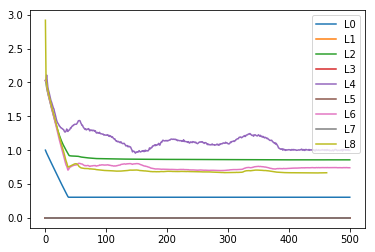

Layer 0: 0.8000 -> 0.8651
Layer 1: 0.8566 -> 0.8893
Layer 2: 0.8073 -> 0.8379
Layer 3: 0.8325 -> 0.8860
Layer 4: 0.6917 -> 0.6932
Layer 5: 0.6566 -> 0.7269
Layer 6: 0.4285 -> 0.3975
Layer 7: 0.4593 -> 0.0987
Layer 8: 0.4131 -> 0.0987


In [16]:
for l,L in enumerate(Ls):
    plt.plot(hist[:,l]/np.abs(hist[:,0]).max(), label='L'+str(l))
plt.legend()
plt.show()

for i in range(len(hardpre)):
    h1 = hardpre[i]
    h2 = hardpost[i]
    print ("Layer {}: {:.4f} -> {:.4f}".format(i,h1,h2))

In [25]:
print (Ls[7].Process.T)

tensor([[ 0.0627, -0.0584],
        [ 0.1927,  0.0875],
        [-0.1992,  0.0060],
        [ 0.0904, -0.2134],
        [ 0.0345,  0.0581],
        [-0.0311,  0.0076],
        [-0.1959, -0.0411],
        [-0.0137,  0.0874],
        [ 0.0505, -0.2164],
        [ 0.0501, -0.1628],
        [ 0.1162,  0.2104],
        [ 0.1934, -0.0235],
        [-0.0709, -0.1253],
        [-0.2435, -0.0099],
        [ 0.0548, -0.0015],
        [-0.0723, -0.1086],
        [ 0.0991,  0.0267],
        [ 0.0976, -0.1357],
        [ 0.0784, -0.1940],
        [ 0.1778,  0.1109],
        [-0.0948, -0.0782],
        [ 0.1648,  0.1274],
        [-0.0105, -0.1881],
        [ 0.1475,  0.1163],
        [ 0.0240,  0.0620],
        [ 0.0321,  0.0115],
        [-0.0621, -0.0660],
        [ 0.2280, -0.0024],
        [-0.0484,  0.2111],
        [-0.2593, -0.1572],
        [-0.1455, -0.1058],
        [-0.1414,  0.1364],
        [-0.1201,  0.1695],
        [-0.1820,  0.0984],
        [-0.1025, -0.0197],
        [ 0.0054,  0

In [ ]:
Gs = [
    [15,20,25,30,30],
    [15,20,25,30,35],
    [15,20,25,40,30],
    [15,20,25,40,60],
    [15,20,30,60,240],
]

hard = np.zeros((len(Gs),len(Ls)))

for j in range(len(Gs)):
    print ("Network Shape: {}".format(Gs[j]))
    Ls, Ns = makeNet(cossim, lambda x:x/x.mean(), device, Gs=Gs[j], lr=[5e-3,0,5e-3])

    for i in range(len(Ls)):
        hard[j, i] = MeasureHardness(Ls[:i+1], Ns, 30, train_loader, epochs=5, lr=5e-3)
        print ("Layer {}: {}".format(i, hard[j,i]))


In [ ]:
device = 'cuda:7'


print (MeasureHardness(LsLG, NsLG, 100, train_loader, lr=5e-3, verbose=True))
LsCS, NsCS = makeNet(cossim, lambda x:x/x.mean(), device)
print (MeasureHardness(LsCS, NsCS, 100, train_loader, lr=5e-3, verbose=True))
LsML, NsML = makeNet(MixtureLogProb, lambda x:x/x.mean(), device)
print (MeasureHardness(LsML, NsML, 100, train_loader, lr=5e-3, verbose=True))
LsMP, NsMP = makeNet(GMMProbs, lambda x:x/x.mean(), device)
print (MeasureHardness(LsMP, NsMP, 100, train_loader, lr=5e-3, verbose=True))

In [ ]:


# Quick test
lr = 5e-3
L0 = CGMN((1,28,28), 15, (3,3), lr=lr).eval()
L0.to(device)

L1 = CGMN((15,26,26), 20, (3,3), stride=2, lr=lr).eval()
L1.to(device)

L2 = CGMN((20,12,12), 25, (3,3), stride=2, lr=lr).eval()
L2.to(device)

L3 = CGMN((25,5,5), 30, (5,5), lr=lr).eval()
L3.to(device)

Ls = [L0, L1, L2, L3]
Ns = [lambda x: x/x.mean()]*len(Ls)

hist = train(Ls, Ns, train_loader, 1, 10, layer_learn=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.legend()
plt.show()

In [ ]:
# Cosine Similarity
def cossim(x, pi, sig, mu):
    x = x.unsqueeze(1)/sig
    mu = mu/sig
    return F.cosine_similarity(x, mu, 2, 1e-8)

func = cossim

lr = 5e-3
L0 = CGMN((1,28,28), 15, (3,3), lr=lr, FeedForward=func).eval()
L0.to(device)

L1 = CGMN((15,26,26), 20, (3,3), stride=2, lr=lr, FeedForward=func).eval()
L1.to(device)

L2 = CGMN((20,12,12), 25, (3,3), stride=2, lr=lr, FeedForward=func).eval()
L2.to(device)

L3 = CGMN((25,5,5), 30, (5,5), lr=lr, FeedForward=func).eval()
L3.to(device)

Ls = [L0, L1, L2, L3]
Ns = [lambda x: x/x.mean()]*len(Ls)

raise ValueError("STOP")

hist = train(Ls, Ns, train_loader, 1, 5, layer_learn=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.legend()
plt.show()

In [ ]:
func = MixtureLogProb

lr = 5e-3
L0 = CLGMN((1,28,28), 15, 15, (3,3), lr=lr, FeedForward=func).eval()
L0.to(device)

L1 = CLGMN((15,26,26), 20, 20, (3,3), stride=2, lr=lr, FeedForward=func).eval()
L1.to(device)

L2 = CLGMN((20,12,12), 25, 25, (3,3), stride=2, lr=lr, FeedForward=func).eval()
L2.to(device)

L3 = CLGMN((25,5,5), 30, 30, (5,5), lr=lr, FeedForward=func).eval()
L3.to(device)

Ls = [L0, L1, L2, L3]
Ns = [lambda x: x/x.mean()]*len(Ls)

raise ValueError("Stop")
hist = train(Ls, Ns, train_loader, 1, 10, layer_learn=True)

plt.plot(hist[:,0]/np.abs(hist[:,0]).max(), label='L0')
plt.plot(hist[:,1]/np.abs(hist[:,1]).max(), label='L1')
plt.plot(hist[:,2]/np.abs(hist[:,2]).max(), label='L2')
plt.plot(hist[:,3]/np.abs(hist[:,3]).max(), label='L3')
plt.legend()
plt.show()

# Inspection of layers
Here is some stuff from the earlier explorations, plotting the activations and the means of the network.

In [25]:
def plotMeans(Ls, sigma=False, stats=False, plot=True):

    for L in Ls:
        (pi, sig, mu) = [x.cpu().detach() for x in L.params()]
        pi = pi.squeeze()
        vp,pp = pi.sort(descending=True)
        print (pp)

        if (plot):
            if (sigma):
                pmu = sig[pp]
            else:
                pmu = mu[pp]
            rows = L.G//5

            fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
            for i in range(L.G):
                px = i//5
                py = i%5
                ax[px,py].imshow(pmu[i,0], cmap='gray')#, vmin=0, vmax=1)
            plt.show()
        
        if (stats):
            print ("Stats:")
            print ("Pi: Max: {} Mean: {} Min:{}".format(pi.max().item(), pi.mean().item(), pi.min().item()))
            print ("Sig: Max: {} Mean: {} Min:{}".format(sig.max().item(), sig.mean().item(), sig.min().item()))
            print ("Mu: Max: {} Mean: {} Min:{}".format(mu.max().item(), mu.mean().item(), mu.min().item()))
            
            
def plotActivations(Ls, Ns, data_loader, nsamples, scale=False, dists=False):
    (data, label) = next(iter(data_loader))
    device = next(Ls[0].parameters()).device
    
    nsamples = 1 if dists else nsamples

    for i in range(nsamples):
        dd = data.to(device)
        
        if (not dists):
            plt.imshow(data[i,0].cpu().detach(), cmap='gray', vmin=0, vmax=1)
            plt.show()

        for l,L in enumerate(Ls):
#             (pi, sig, mu) = [x.cpu().detach() for x in L.params()]
#             pi = pi.squeeze()
#             vp,pp = pi.sort(descending=True)

            rows = L.G//5
            rows = rows if rows > 1 else 2
            print (rows)

            (y,_) = L(dd)
            
            # Normalize
            if (Ns is None):
                dd = y
            else:
                dd = Ns[l](y)
            
            # Activate scaling only if its a 1x1 image
            if (np.prod(dd[i,0].shape) == 1 or scale):
                vmin = dd[i].min()
                vmax = dd[i].max()
            else:
                vmin = None
                vmax = None

            fig, ax = plt.subplots(rows,5, sharex=True, sharey=True, figsize=(10, 2*rows))
            for j in range(L.G):
                px = j//5
                py = j%5
                
                if (dists):
                    ax[px,py].hist(y[:,j].cpu().detach().flatten(), bins=50)
                else:
                    ax[px,py].imshow(y[i,j].cpu().detach(), cmap='gray', vmin=vmin, vmax=vmax)
            plt.show()




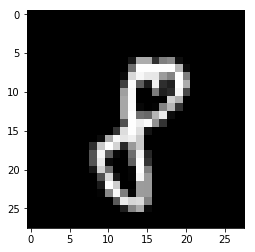

3


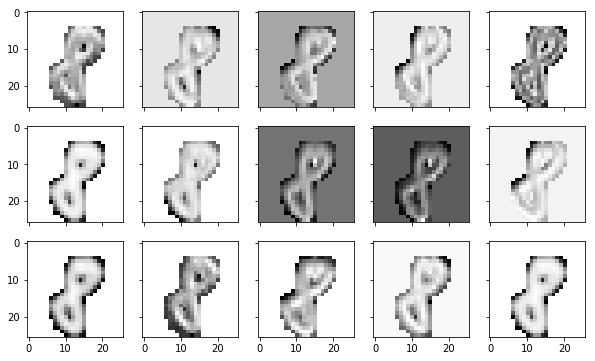

2


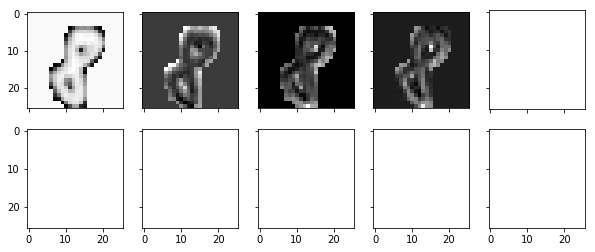

4


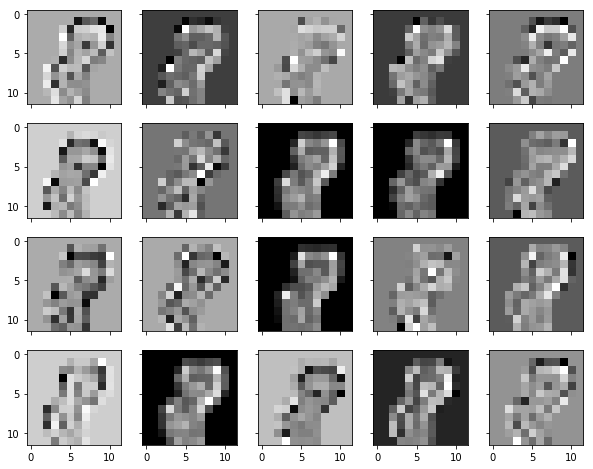

2


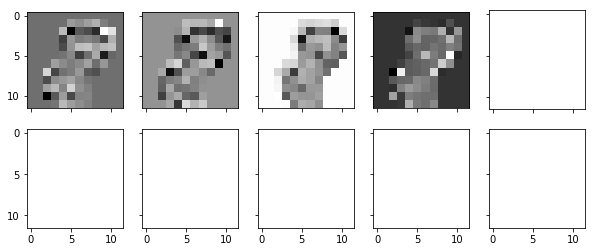

6


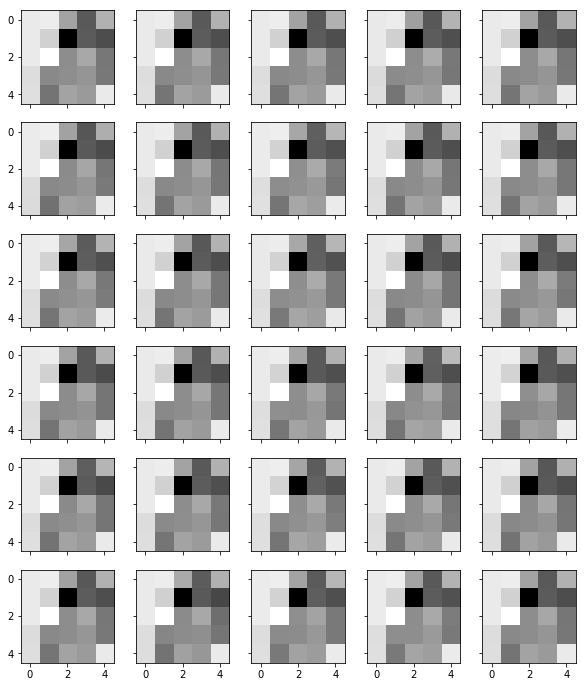

2


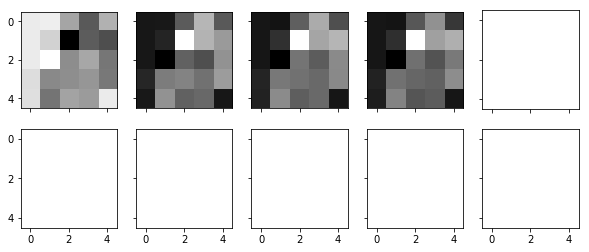

12


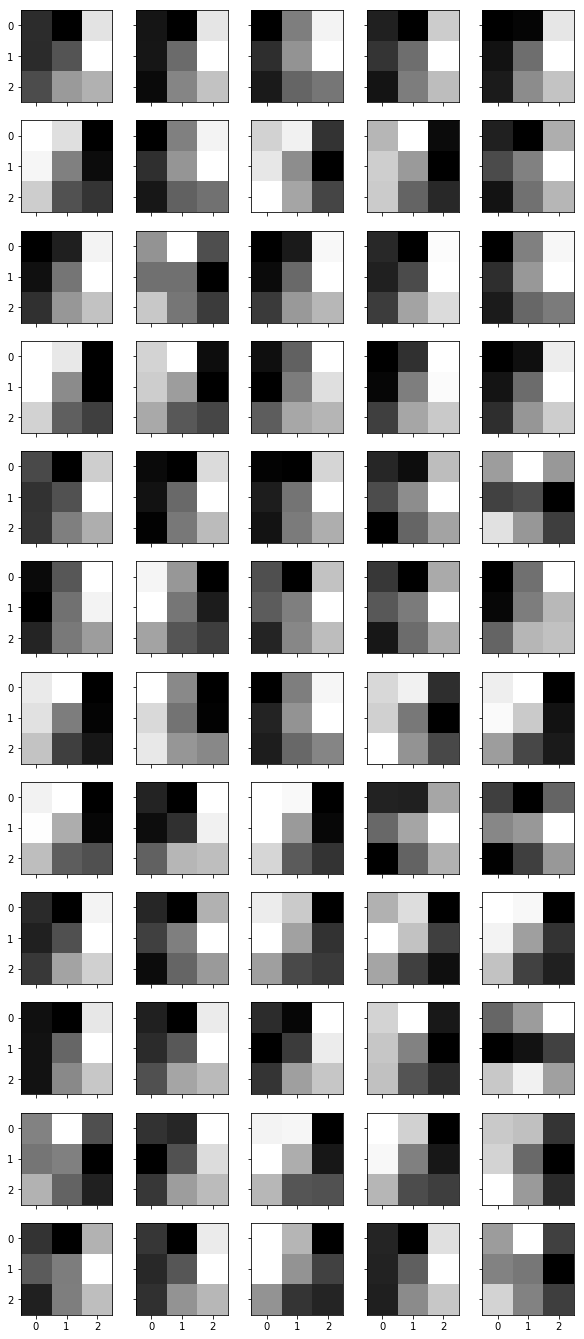

2


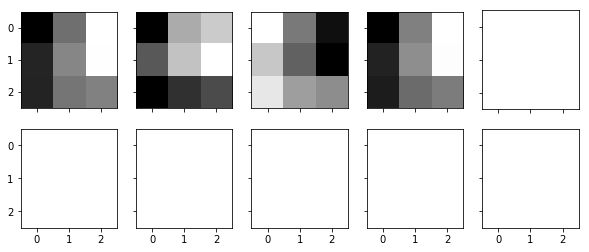

48


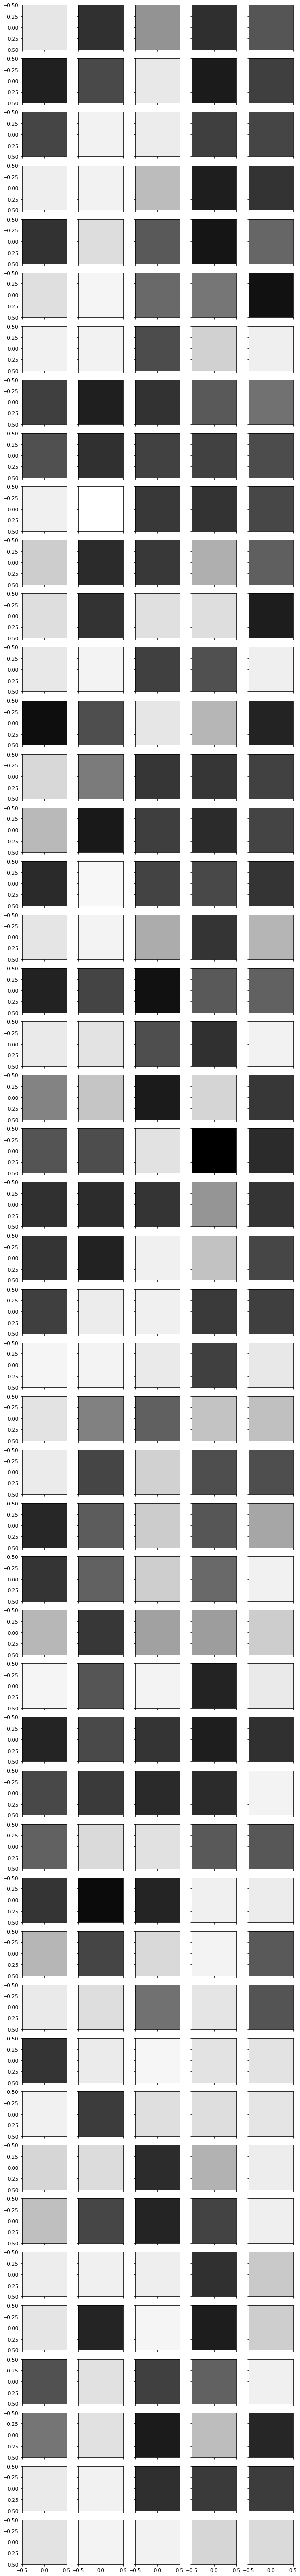

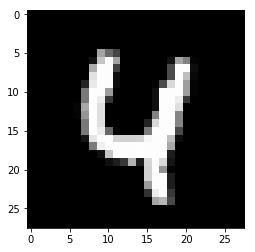

3


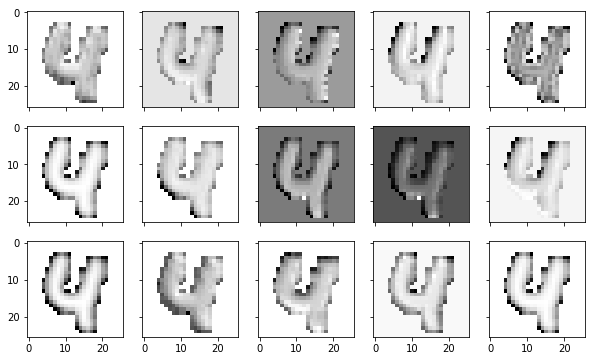

2


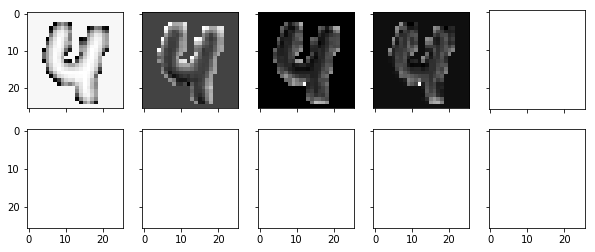

4


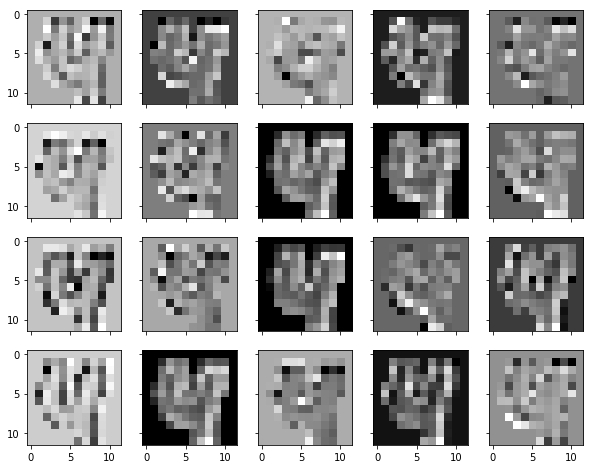

2


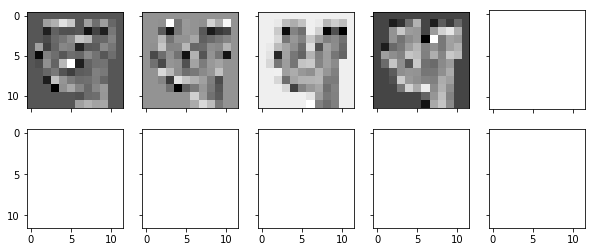

6


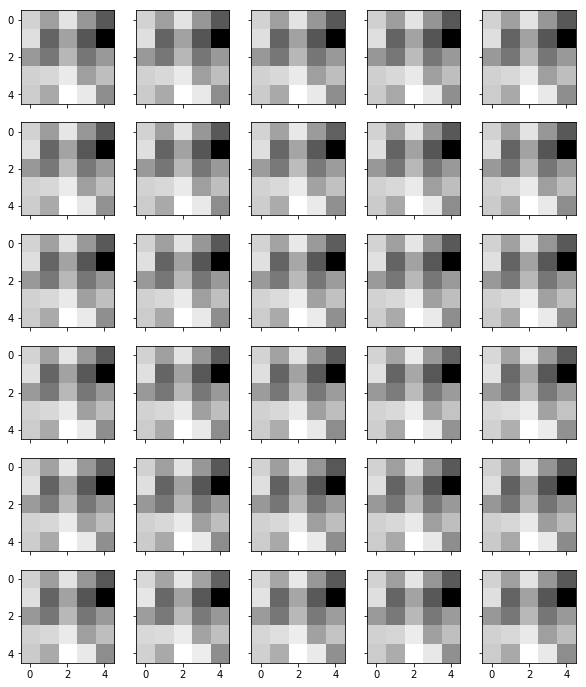

2


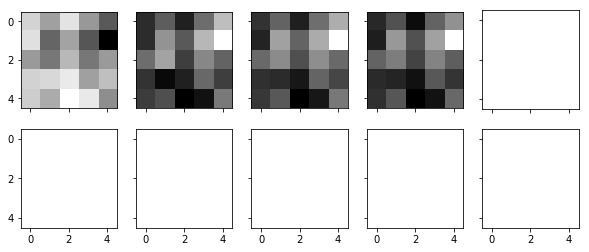

12


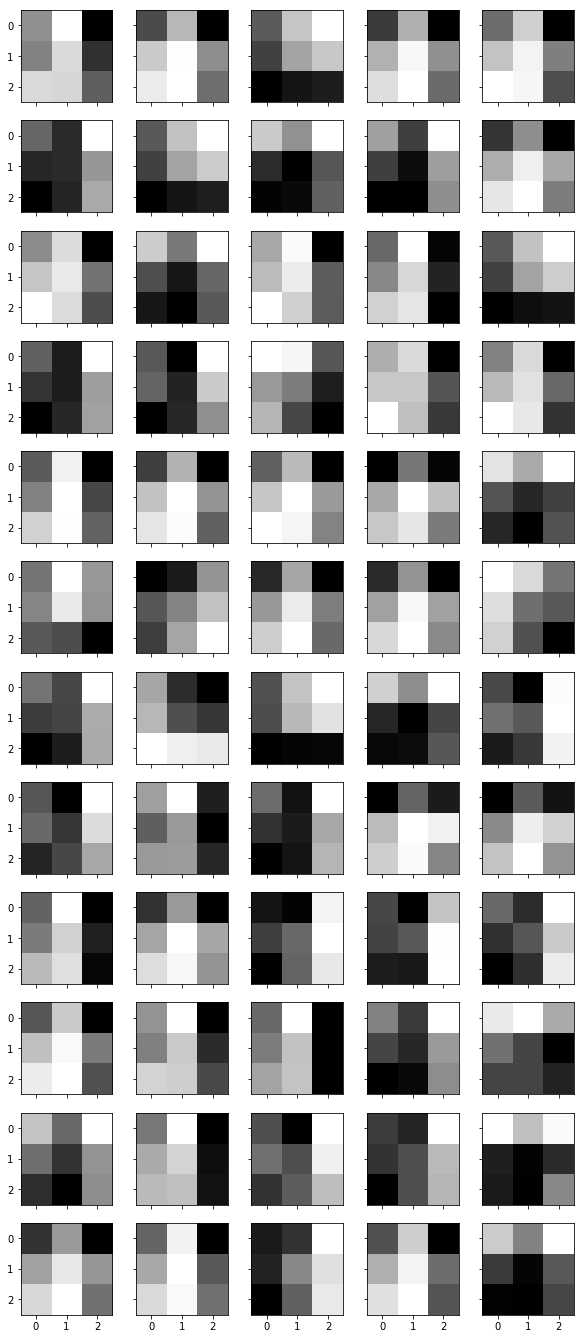

2


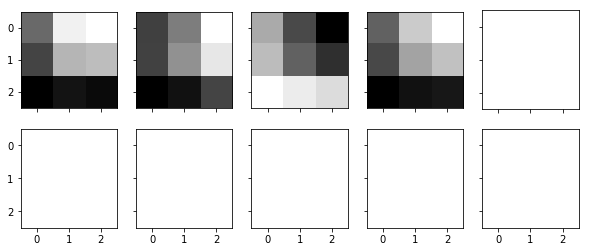

48


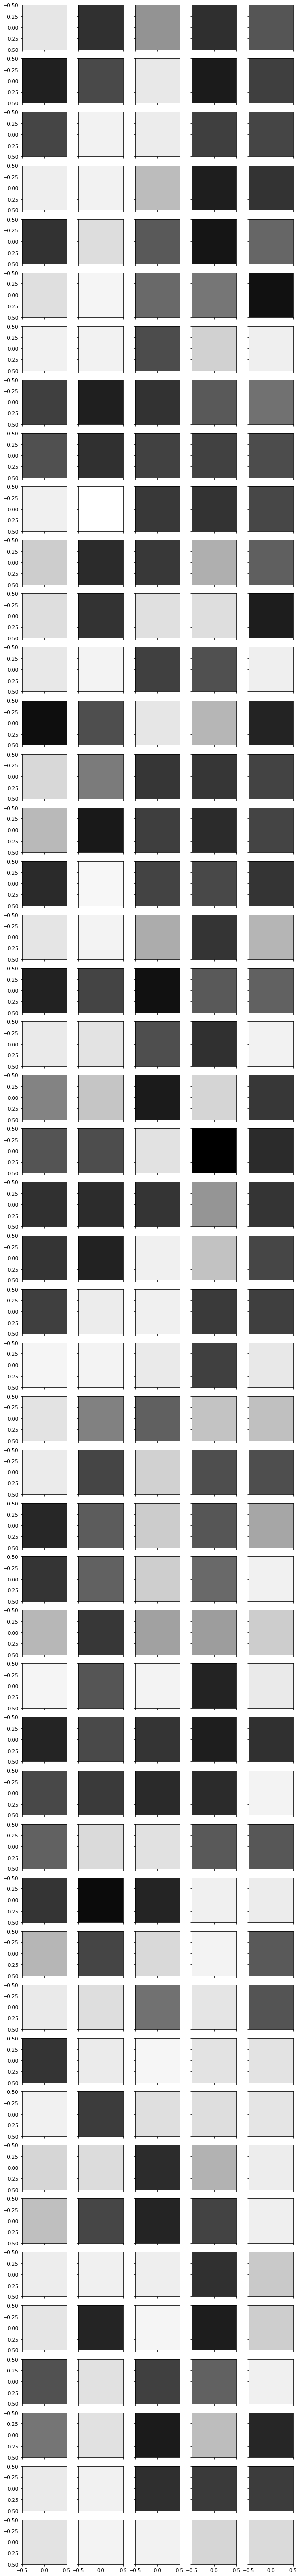

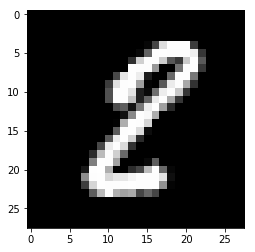

3


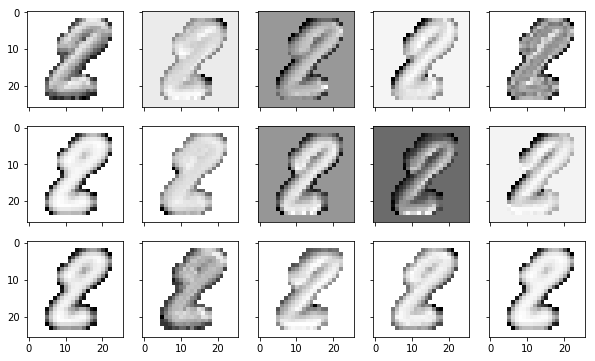

2


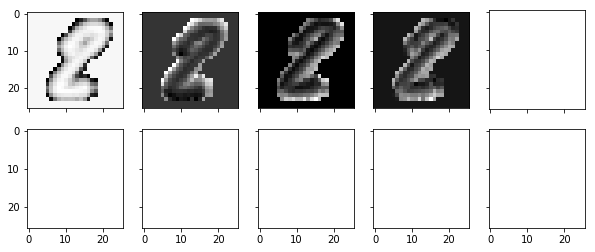

4


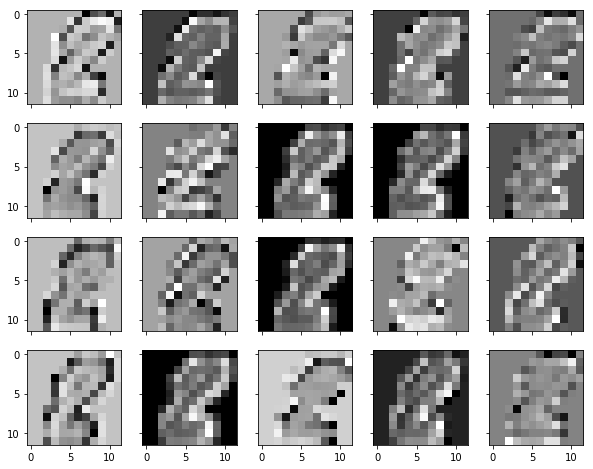

2


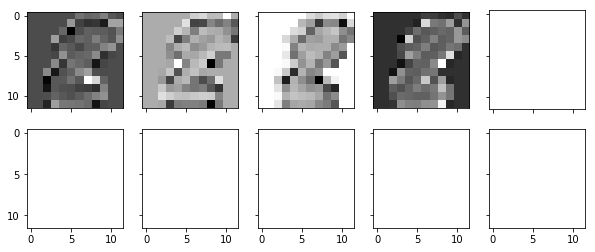

6


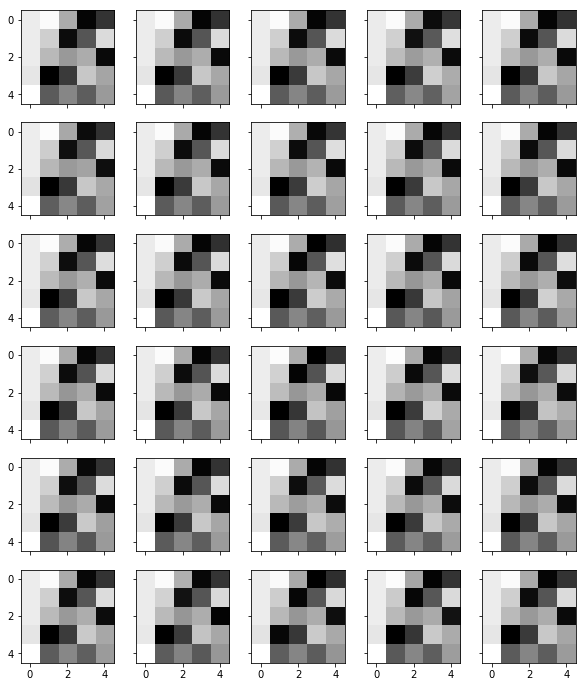

2


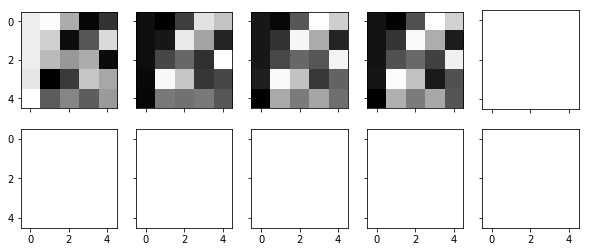

12


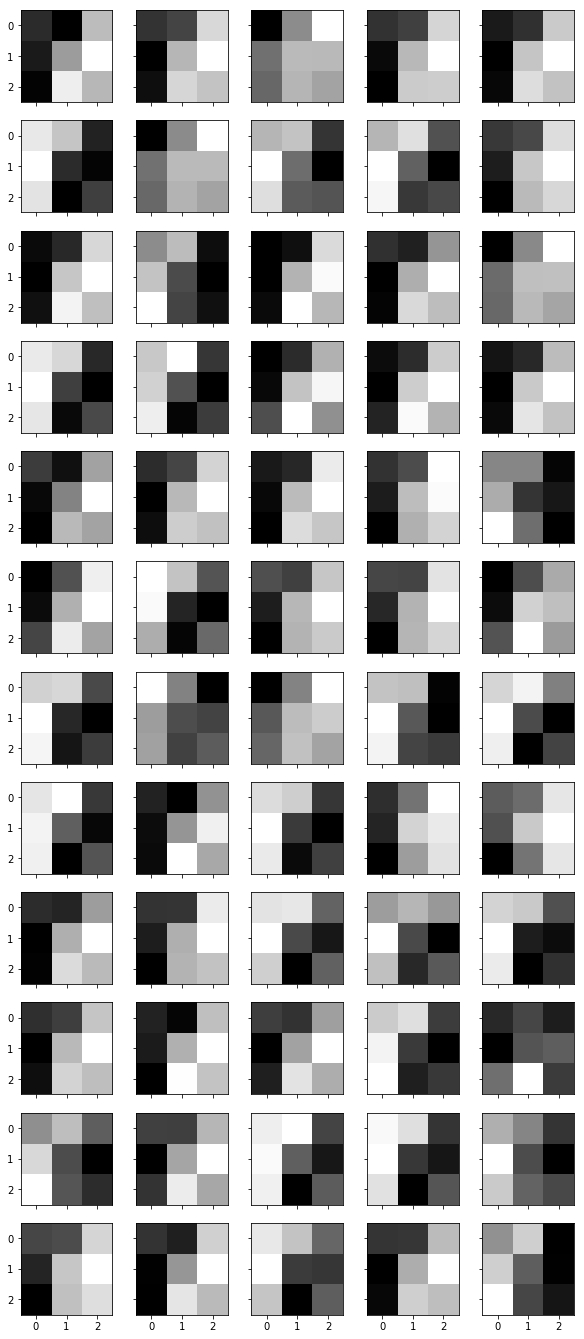

2


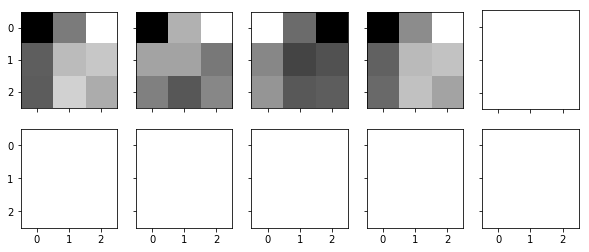

48


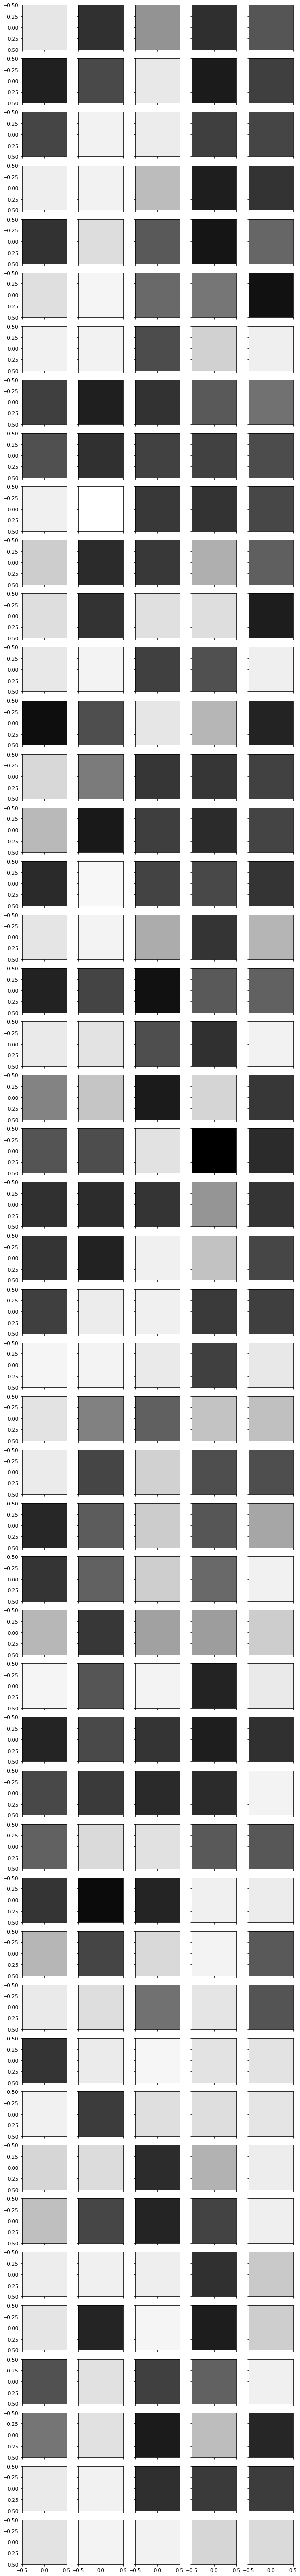

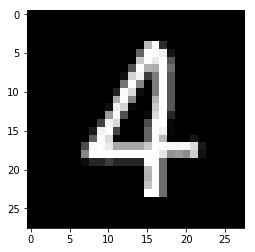

3


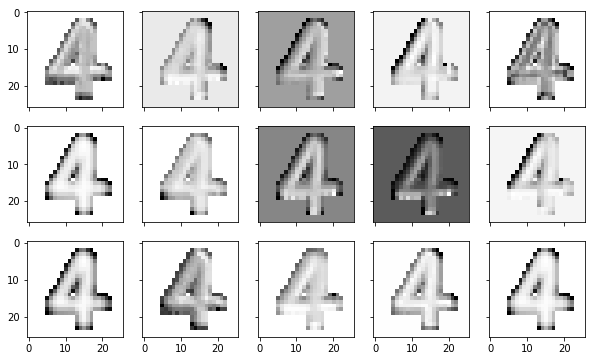

2


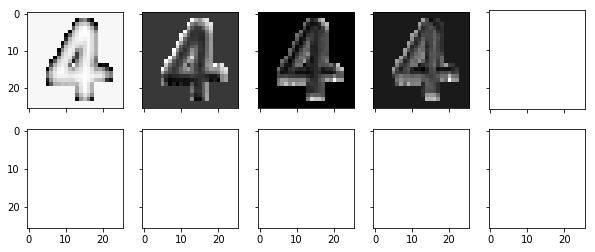

4


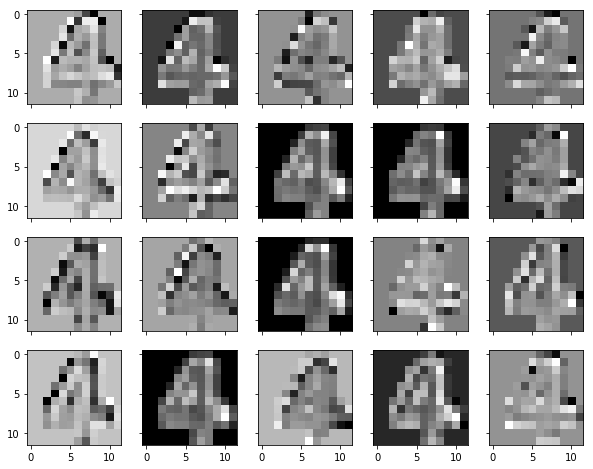

2


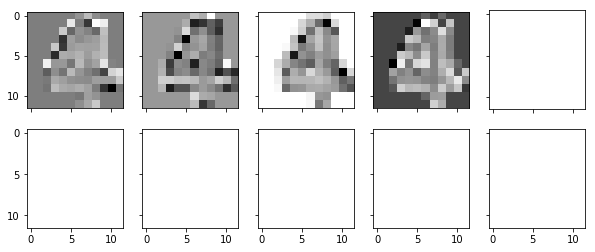

6


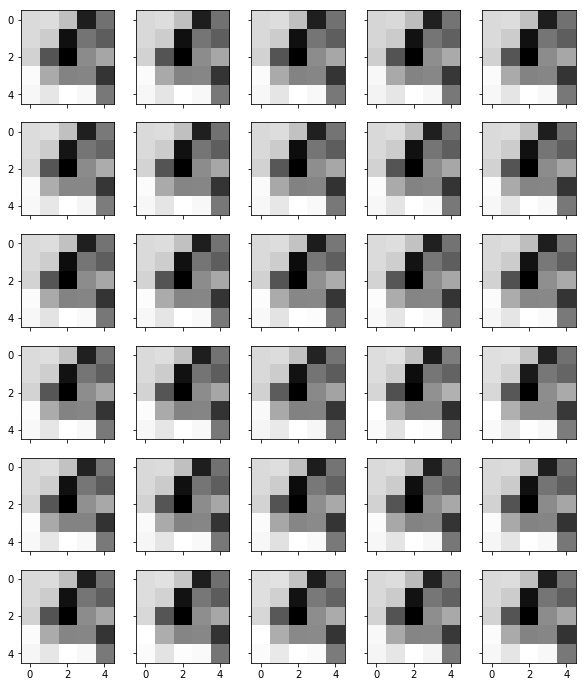

2


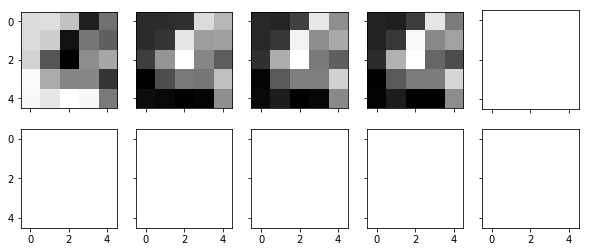

12


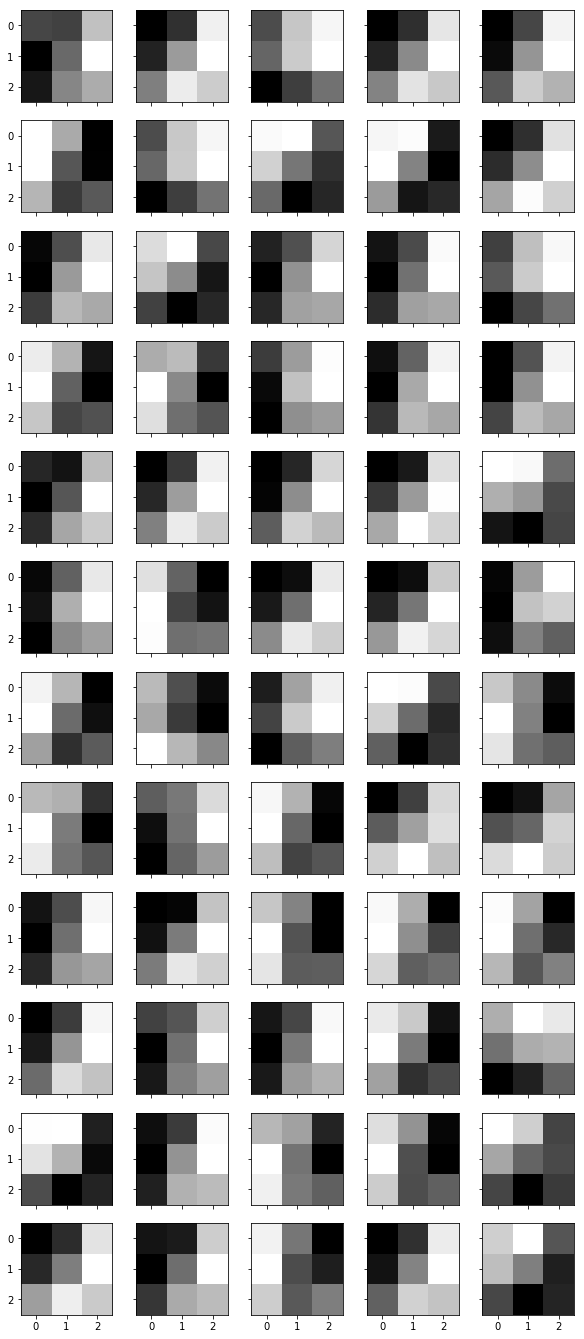

2


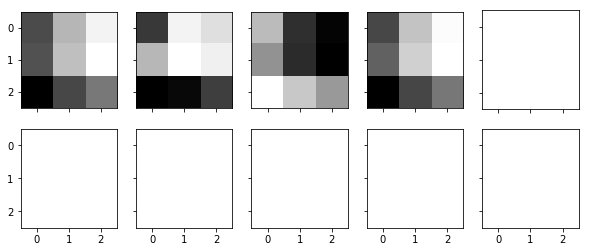

48


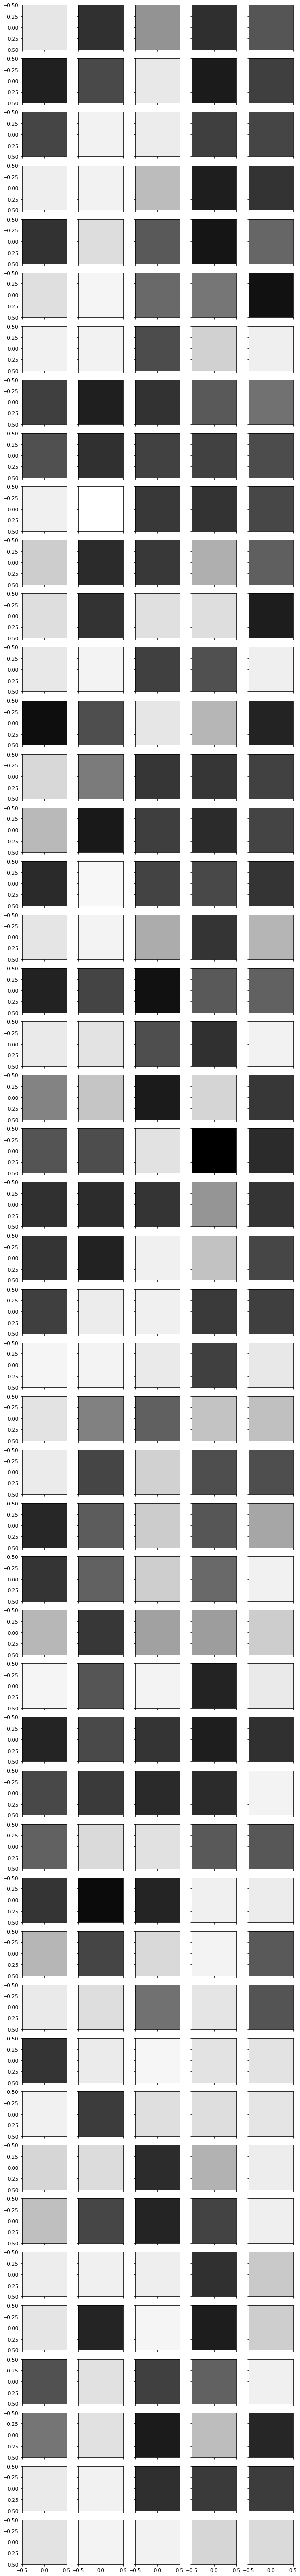

In [37]:
# plotMeans(Ls[::2], stats=True, plot=False)
plotActivations(Ls, Ns, big_batch, 4)

In [4]:
class DeepCGMN(nn.Module):
    def __init__(self, N=lambda x:x, lr=1e-3):
        super().__init__()
        
        self.C0 = CGMN((1,28,28), 15, (3,3), lr=lr)
        self.C1 = CGMN((15,26,26), 20, (3,3), stride=2, lr=lr)
        self.C2 = CGMN((20,12,12), 25, (3,3), stride=2, lr=lr)
        self.C3 = CGMN((25,5,5), 30, (5,5), lr=lr)
        
        self.N = N
        
    def forward(self, x):
        (x1, _) = self.C0(x)
        x1 = self.N(x1)
        (x2, _) = self.C1(x1)
        x2 = self.N(x2)
        (x3, _) = self.C2(x2)
        x3 = self.N(x3)
        (y, _) = self.C3(x3)
        
        return y
    
    def learn(self, x, lr=None):
        (x1, _) = self.C0(x)
        x1 = self.N(x1)
        (x2, _) = self.C1(x1)
        x2 = self.N(x2)
        (x3, _) = self.C2(x2)
        x3 = self.N(x3)
        
        self.C0.learn(x, lr)
        self.C1.learn(x1, lr)
        self.C2.learn(x2, lr)
        self.C3.learn(x3, lr)
        
class ShellNet():
    def __init__(self, Ls, Ns):
        self.Ls = Ls
        self.Ns = Ns
    
    def forward(data):
        device = next(Ls[0].parameters()).device
        dd = data.to(device)

        for l,L in enumerate(Ls):
            (y,_) = L(dd)

            # Normalize
            if (Ns is None):
                dd = y
            else:
                dd = Ns[l](y)
                
        return dd
     
        